# Yelp DataSet: 
# Negative Reviews Analysis + Recommendation Engine System

## 1. Required Packages

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud 
from sklearn.metrics.pairwise import cosine_similarity

## 2. Load and Understanding of Data

In [127]:
def load_csv_file(path):
    df = pd.read_csv(path)
    return df

In [131]:
business = load_csv_file("data/business100000.csv")
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [129]:
reviews = load_csv_file("data/reviews100000.csv")
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,6A4ET4I9Wac0go2NgGlM_Q,54te-6CafvNMKokcJha2rQ,F70couxLlxWDRZNIVHoIRA,5,2011-02-16,"As a girl, it's always intimidating to take my...",4,1,2
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,The service here is absolutely horrible....we ...,1,1,0
2,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,Great restaurant w\/ impeccable service and ve...,0,0,0
3,6Jq9eS2n71nQVxeon1EVbQ,K7W2UaUGJvpbqiqObRhQQQ,DYAorbxOyubUB_wtQRCdug,4,2012-09-09,Had the grasshopper iced coffee. Better than d...,1,0,1
4,lqOtgd34OLoDkJGo7o147Q,K7W2UaUGJvpbqiqObRhQQQ,K0j_Znzin0jShXVnpvW86A,3,2014-11-11,I found this place to be pretty mediocre. I wa...,0,0,0


In [7]:
## I will check for the basic info, so I can have a better understanding about the data

#Checking original shapes: number of columns and rows
print(f'The shape of reviews df is: {reviews.shape}')
#Checking columns, datatypes, null values..
print(f'----------------------------------------------')
print(reviews.info())


The shape of reviews df is: (61668, 9)
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61668 entries, 0 to 61667
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    61668 non-null  object
 1   user_id      61668 non-null  object
 2   business_id  61668 non-null  object
 3   stars        61668 non-null  int64 
 4   date         61668 non-null  object
 5   text         61668 non-null  object
 6   useful       61668 non-null  int64 
 7   funny        61668 non-null  int64 
 8   cool         61668 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 4.2+ MB
None


In [8]:
#Same for business info
print(f'The shape of business df is: {business.shape}')
print(f'----------------------------------------------')
print(business.info())

The shape of business df is: (100000, 13)
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   100000 non-null  object 
 1   name          100000 non-null  object 
 2   neighborhood  39252 non-null   object 
 3   address       100000 non-null  object 
 4   city          100000 non-null  object 
 5   state         99999 non-null   object 
 6   postal_code   99650 non-null   object 
 7   latitude      100000 non-null  float64
 8   longitude     100000 non-null  float64
 9   stars         100000 non-null  float64
 10  review_count  100000 non-null  int64  
 11  is_open       100000 non-null  int64  
 12  categories    100000 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 9.9+ MB
None


In [9]:
## I want to see what are the most common categories of business
business["categories"].value_counts(normalize=True)[:10]

Restaurants;Pizza            0.00585
Pizza;Restaurants            0.00568
Food;Coffee & Tea            0.00558
Mexican;Restaurants          0.00555
Coffee & Tea;Food            0.00546
Nail Salons;Beauty & Spas    0.00535
Beauty & Spas;Nail Salons    0.00520
Chinese;Restaurants          0.00506
Restaurants;Mexican          0.00503
Restaurants;Chinese          0.00503
Name: categories, dtype: float64

## 3. Basic Statistics and Plots

## 3.1 Basic Cleaning

In [10]:
## I check what columns are composed mainly per null values - and then remove the column
business.isna().sum()

business_id         0
name                0
neighborhood    60748
address             0
city                0
state               1
postal_code       350
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
categories          0
dtype: int64

In [11]:
## I just want to work with RESTAURANTS that are still open, I will remove columns that are not useful in this case
def clean_business_df(df):
    df = df[df['is_open']==1]
    drop_columns = ['is_open','review_count', 'neighborhood', 'postal_code']
    df = df.copy()
    df = df.drop(drop_columns, axis=1)
    df = df[df['categories'].str.contains('Restaurants;')]
    return df

In [12]:
business = clean_business_df(business)
business.head()

,business_id,name,address,city,state,latitude,longitude,stars,categories
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""","""600 E 4th St""",Charlotte,NC,35.221647,-80.839345,3.5,Restaurants;American (Traditional)
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""","""1058 Gerrard Street E""",Toronto,ON,43.669256,-79.335902,3.5,Tiki Bars;Nightlife;Mexican;Restaurants;Bars
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""","""2777 Steeles Avenue W""",Toronto,ON,43.781816,-79.490433,5.0,Restaurants;Breakfast & Brunch
33,FXHfcFVEfI1vVngW2gVOpw,"""Bampot House of Tea & Board Games""","""201 Harbord Street""",Toronto,ON,43.661582,-79.408878,4.0,Coffee & Tea;Restaurants;Food;Mediterranean;Te...
40,tRVx2c89coruPRwYhGTcTw,"""Yuzu""","""13603 Madison Ave""",Lakewood,OH,41.476846,-81.786971,3.5,Nightlife;Izakaya;Comfort Food;Cocktail Bars;A...


In [13]:
## Now I need to merge both dataframes: business & reviews info - this will let me to "join" the business with its respective reviews
def merge_finaldf(df1, df2, column):
    df = pd.merge(df1, df2, on=column, how='left')
    df = df.drop(columns={"stars_y"})#, axis=True)
    df = df.rename(columns={"stars_x": "stars"})
    df = df.dropna(axis=0, subset=["categories"])
    return df

In [14]:
df = merge_finaldf(reviews, business, 'business_id')
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,The service here is absolutely horrible....we ...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican
2,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,Great restaurant w\/ impeccable service and ve...,0,0,0,"""Beauty & Essex""","""3708 S Las Vegas Blvd""",Las Vegas,NV,36.110199,-115.175373,Restaurants;American (New);Lounges;Bars;Tapas ...
3,6Jq9eS2n71nQVxeon1EVbQ,K7W2UaUGJvpbqiqObRhQQQ,DYAorbxOyubUB_wtQRCdug,4,2012-09-09,Had the grasshopper iced coffee. Better than d...,1,0,1,"""MadHouse Coffee""","""8470 W Desert Inn Rd, Ste H-1""",Las Vegas,NV,36.129857,-115.275526,Food;Sandwiches;American (New);Coffee & Tea;Re...
10,oDAl3BEJ1zofQzRku70rUw,K7W2UaUGJvpbqiqObRhQQQ,a0v7Si0DK4cIko7AQY4YXg,5,2017-05-30,I do love me some Egg Works. My hands down fav...,0,0,0,"""Egg Works""","""6960 S Rainbow Blvd""",Las Vegas,NV,36.062194,-115.241856,Breakfast & Brunch;Restaurants;American (Tradi...
14,F0NSESUr0_LtfZe9ZYh8uA,K7W2UaUGJvpbqiqObRhQQQ,Se-co1eXBho5A4YwMfKMIQ,4,2017-05-30,Very tasty breakfast here this weekend. Had a ...,0,0,0,"""Griddlecakes""","""6085 S Fort Apache, Ste 180""",Las Vegas,NV,36.078260,-115.298559,Breakfast & Brunch;Salad;Restaurants;Sandwiches


## 4. Data Cleaning for NLP and Vectorization

Now I need to to the usual cleaning that is needed to work in NLP tasks: remove numbers, special characters, remove spaces, also remove STOPWORDS and tokenize.

In [15]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') 
    
    sentence = sentence.strip()
    
    return sentence

In [16]:
df["text"] = df["text"].apply(basic_cleaning)
df.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,the service here is absolutely horriblewe have...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican
2,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,great restaurant w impeccable service and very...,0,0,0,"""Beauty & Essex""","""3708 S Las Vegas Blvd""",Las Vegas,NV,36.110199,-115.175373,Restaurants;American (New);Lounges;Bars;Tapas ...


In [17]:
def stop_words(text):
        text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
        return text

In [18]:
df["text"] = df["text"].apply(stop_words)
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,service absolutely horriblewe eaten many times...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican
2,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,great restaurant w impeccable service good foo...,0,0,0,"""Beauty & Essex""","""3708 S Las Vegas Blvd""",Las Vegas,NV,36.110199,-115.175373,Restaurants;American (New);Lounges;Bars;Tapas ...
3,6Jq9eS2n71nQVxeon1EVbQ,K7W2UaUGJvpbqiqObRhQQQ,DYAorbxOyubUB_wtQRCdug,4,2012-09-09,grasshopper iced coffee better dessert great l...,1,0,1,"""MadHouse Coffee""","""8470 W Desert Inn Rd, Ste H-1""",Las Vegas,NV,36.129857,-115.275526,Food;Sandwiches;American (New);Coffee & Tea;Re...
10,oDAl3BEJ1zofQzRku70rUw,K7W2UaUGJvpbqiqObRhQQQ,a0v7Si0DK4cIko7AQY4YXg,5,2017-05-30,love egg works hands favorite santa cruz burri...,0,0,0,"""Egg Works""","""6960 S Rainbow Blvd""",Las Vegas,NV,36.062194,-115.241856,Breakfast & Brunch;Restaurants;American (Tradi...
14,F0NSESUr0_LtfZe9ZYh8uA,K7W2UaUGJvpbqiqObRhQQQ,Se-co1eXBho5A4YwMfKMIQ,4,2017-05-30,tasty breakfast weekend pretty basic eggs easy...,0,0,0,"""Griddlecakes""","""6085 S Fort Apache, Ste 180""",Las Vegas,NV,36.078260,-115.298559,Breakfast & Brunch;Salad;Restaurants;Sandwiches


In [19]:
import nltk
def tokenize(data):
    tokenized = nltk.word_tokenize(data)
    return tokenized

In [20]:
df["tokens"] = df["text"].apply(tokenize)
df.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories,tokens
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,service absolutely horriblewe eaten many times...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican,"[service, absolutely, horriblewe, eaten, many,..."
2,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,great restaurant w impeccable service good foo...,0,0,0,"""Beauty & Essex""","""3708 S Las Vegas Blvd""",Las Vegas,NV,36.110199,-115.175373,Restaurants;American (New);Lounges;Bars;Tapas ...,"[great, restaurant, w, impeccable, service, go..."


In [21]:
## I check basic info about this new resultant df
print(f'The shape of merged and processed df is: {df.shape}')
print(f'----------------------------------------------')
print(df.info())

The shape of merged and cleaned df is: (12931, 17)
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12931 entries, 1 to 61667
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    12931 non-null  object 
 1   user_id      12931 non-null  object 
 2   business_id  12931 non-null  object 
 3   stars        12931 non-null  int64  
 4   date         12931 non-null  object 
 5   text         12931 non-null  object 
 6   useful       12931 non-null  int64  
 7   funny        12931 non-null  int64  
 8   cool         12931 non-null  int64  
 9   name         12931 non-null  object 
 10  address      12931 non-null  object 
 11  city         12931 non-null  object 
 12  state        12931 non-null  object 
 13  latitude     12931 non-null  float64
 14  longitude    12931 non-null  float64
 15  categories   12931 non-null  object 
 16  tokens       12931 non-null  obj

## 5. Understanding the reasons behind a bad review - TfIdf

We are interested in understand bad reviews. I will use TFIDF to analyse importance of every word in a single "document" or in the entire corpus (the column "text")

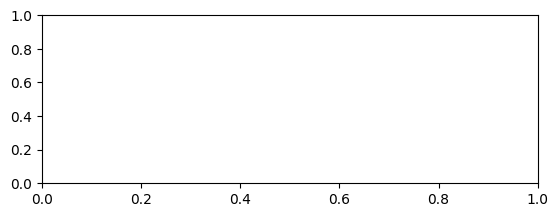

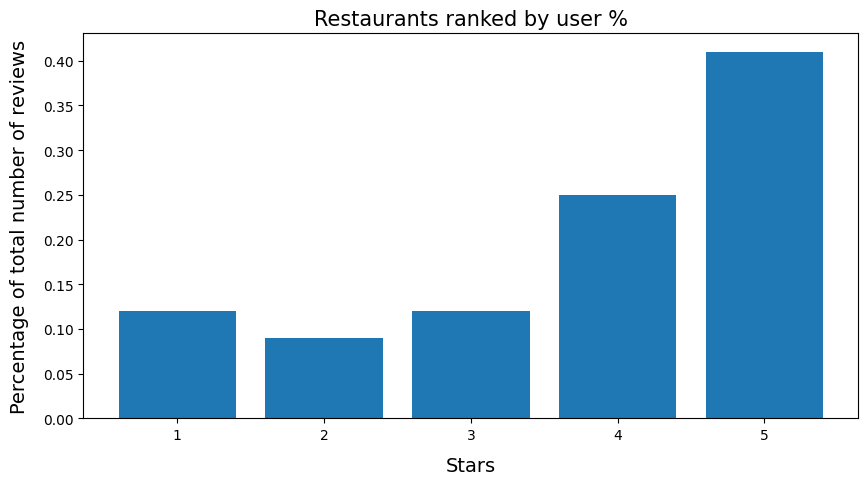

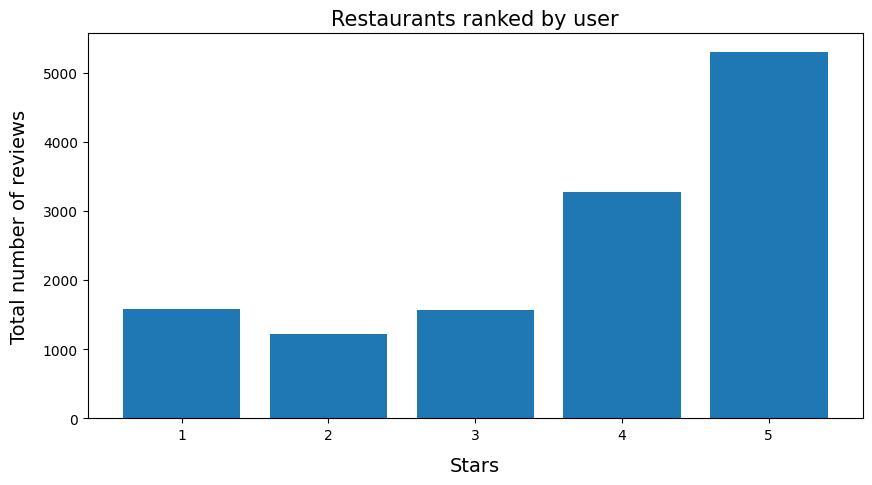

In [126]:
# Lets plot the frequency and relative frequency of "stars"

plt.subplot(2, 1, 1)
plt.figure(figsize=(10,5))
percentage_stars = round(df["stars"].value_counts(normalize = True),2)
plt.bar(percentage_stars.index, percentage_stars.values)
plt.ylabel('Percentage of total number of reviews', fontsize=14, labelpad=10)
plt.xlabel('Stars', fontsize=14, labelpad=10)
plt.title('Restaurants ranked by user %', fontsize=15)

plt.figure(figsize=(10,5))
total_stars = df["stars"].value_counts()
plt.bar(total_stars.index, total_stars.values)
plt.ylabel('Total number of reviews', fontsize=14, labelpad=10)
plt.xlabel('Stars', fontsize=14, labelpad=10)
plt.title('Restaurants ranked by user', fontsize=15)
plt.show()

In [99]:
# I am interested in working only with negative reviews, I decide to work with really negative stars (3 stars is a mild bad experience, so in certain way
# is also a good experience). Also I will remove very common words that are unuseful to get better results in the TFIDF
bad_reviews = df[df["stars"]<=2]
unuseful_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous','bad','disappointed','unfortunately','disappointing','horrible',
                                                    'lacking','terrible','sorry', 'would', 'recommend', 'like', 'come', 'again', 'back',
                                                    'came', 'never', 'last', 'every', 'know', 'even']

bad_reviews["text_1"] = bad_reviews["text"].str.replace('|'.join(unuseful_words), '', regex=True).str.strip()
bad_reviews.shape

C:\Users\murre\AppData\Local\Temp\ipykernel_8104\3949077281.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_reviews["text_1"] = bad_reviews["text"].str.replace('|'.join(unuseful_words), '', regex=True).str.strip()


(2801, 18)

In [100]:
bad_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories,tokens,text_1
1,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,service absolutely horriblewe eaten many times...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican,"[service, absolutely, horriblewe, eaten, many,...",service absolutely we eaten many times time ho...
30,YmpsQjaw4KQEFPvs82Ufng,tQ2FeQnaWu9TFx9zm_v4wQ,f4x1YBxkLrZg652xt2KR5g,2,2015-08-04,service upon waiting roughly minutes server ta...,0,0,0,"""Hash House A Go Go""","""3535 Las Vegas Blvd""",Las Vegas,NV,36.118181,-115.171580,American (New);Restaurants;Breakfast & Brunch,"[service, upon, waiting, roughly, minutes, ser...",service upon waiting roughly minutes server ta...
59,p_ApwcRU-GXMT9RjrSd37w,gHBPm597gLQ3CU7iR72Lvg,SmkGXa3XVZTXV04IcBkwLg,2,2015-03-31,ordered online realized put pick instead deliv...,1,0,0,"""Jimmy John's""","""2204 W Charleston Blvd""",Las Vegas,NV,36.159091,-115.172108,Delis;Restaurants;Food;Sandwiches;Food Deliver...,"[ordered, online, realized, put, pick, instead...",ordered online realized put pick instead deliv...
75,Lfe5oRYlxfCfQ1YgWgUKww,RFs7m95Iw41Q4jq9X7td_g,ujHiaprwCQ5ewziu0Vi9rw,2,2010-11-30,sure big deal live midsize us city city kind b...,0,0,0,"""The Buffet at Bellagio""","""3600 S Las Vegas Blvd""",Las Vegas,NV,36.113220,-115.176890,Buffets;Restaurants;American (New),"[sure, big, deal, live, midsize, us, city, cit...",sure big deal live midsize us city city kind b...
91,pjbu1VZayrtOqsi9FkttLw,m-2KR6qlnAwsPiK9l2C6kw,7_Eh1VvtKPmQvYNB1OTGWw,1,2017-10-23,went grab coffee half half bottle empty took c...,0,0,0,"""Panera Bread""","""7510 Pineville Matthews Rd""",Charlotte,NC,35.087992,-80.846242,Breakfast & Brunch;Restaurants;Salad;Sandwiche...,"[went, grab, coffee, half, half, bottle, empty...",went grab coffee half half bottle empty took c...


In [101]:
# I create a matrix of TF-IDF features using the raw text
vectorizer = TfidfVectorizer(ngram_range = (2,2), 
                             min_df=0.01, 
                             max_df = 0.05).fit(bad_reviews["text_1"])

In [102]:
# Transform the matrix in a df
vectors = pd.DataFrame(vectorizer.transform(bad_reviews["text_1"]).toarray(),
                       columns = vectorizer.get_feature_names_out())
vectors.head()

,another minutes,around pm,could give,didnt get,didnt want,dont get,dont think,dont want,drink order,drive thru,...,took forever,took minutes,took order,two stars,wait minutes,wait staff,waited minutes,waste money,waste time,worst service
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.553093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.592377,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Sum of the vectors
sum_tfidf = vectors.sum(axis = 0)
sum_tfidf

another minutes    25.096392
around pm          21.773284
could give         20.977854
didnt get          29.754733
didnt want         32.359136
                     ...    
wait staff         33.989366
waited minutes     35.710386
waste money        26.862232
waste time         22.745529
worst service      23.159225
Length: 62, dtype: float64

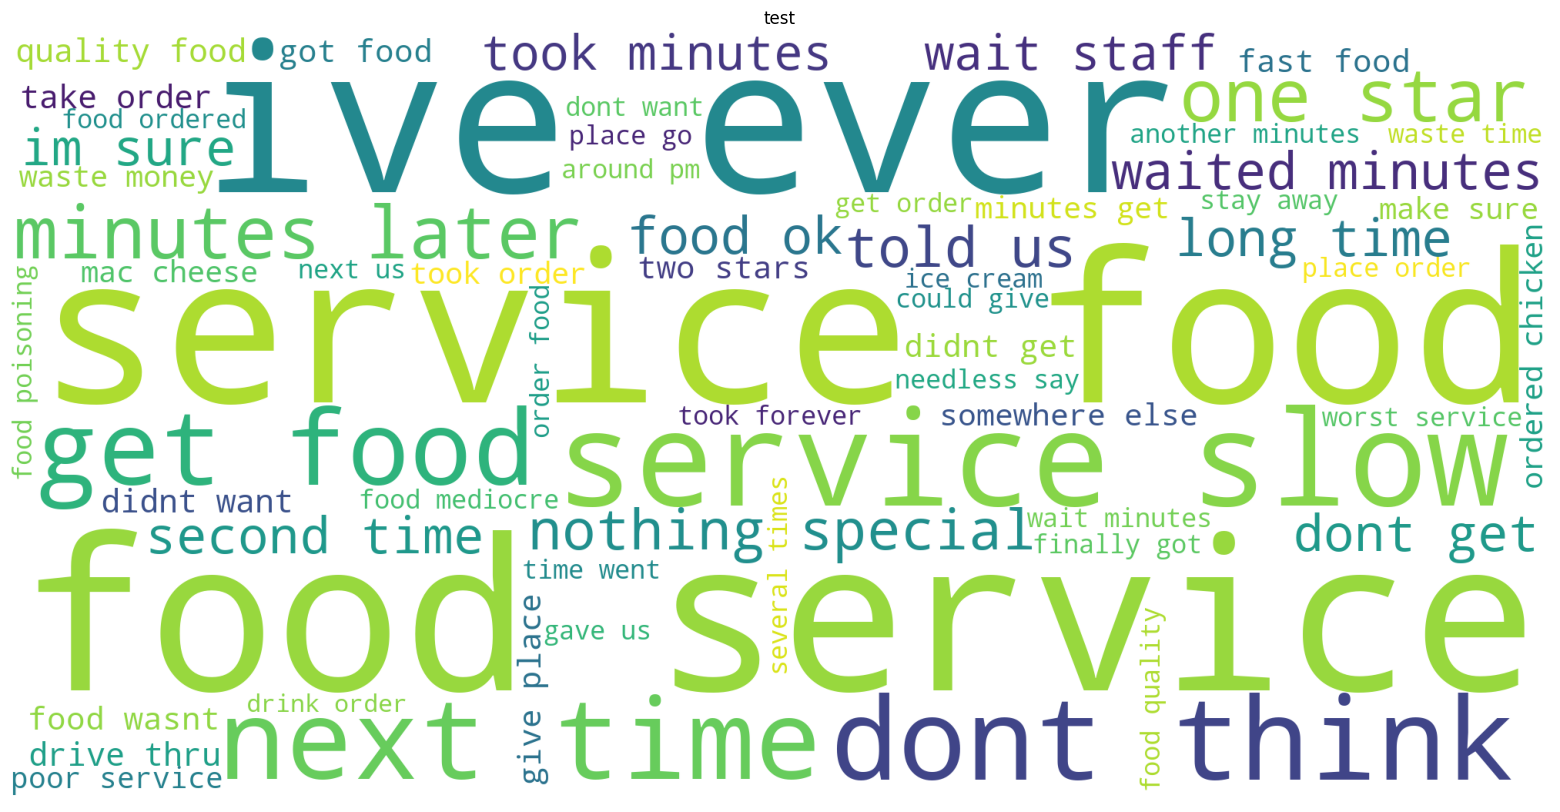

In [104]:
## I plot a word cloud with the most frequent terms
plt.figure(figsize=(20,10))
wordcloud=WordCloud(background_color='white',mode="RGB", width=2000 , height=1000).generate_from_frequencies(sum_tfidf.T)
plt.title("test")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [105]:
# I create a list with the most frequent terms
tfidf_list = [(word, sum_tfidf[word]) 
              for word, idx in vectorizer.vocabulary_.items() 
              if word in vectorizer.vocabulary_.keys() ]
tfidf_list

[('drink order', 17.827771101035413),
 ('another minutes', 25.09639237954194),
 ('order food', 21.34117631088805),
 ('time went', 22.16349653569978),
 ('didnt get', 29.75473302434185),
 ('service food', 52.140706896920314),
 ('quality food', 33.38242387903221),
 ('make sure', 26.705391354521822),
 ('take order', 32.125850700473016),
 ('somewhere else', 28.4331789588178),
 ('long time', 35.2314576776354),
 ('second time', 34.628448762554385),
 ('got food', 29.332499166794847),
 ('waste money', 26.862231696159103),
 ('service slow', 43.56153578000511),
 ('food ok', 35.13537591897218),
 ('ice cream', 24.45917268790081),
 ('worst service', 23.159224990568525),
 ('waste time', 22.74552941509292),
 ('next us', 20.341597816745534),
 ('wait minutes', 20.792231499885958),
 ('place order', 24.072490759644246),
 ('fast food', 29.917755218393083),
 ('wait staff', 33.98936604375659),
 ('dont get', 34.484765390042895),
 ('ordered chicken', 26.347548457837636),
 ('took forever', 25.463334296910393),


### *Conclusion*: Main reasons behind a bad review are related mainly to long wait times, quality food, restaurant staff services, problems with the orders and drinks that never arrived.


## 6. Content based recommendation engine for restaurants in the US

I will a create content based recommendation engine for this restaurants, so we can suggest restaurants based on content similarity

In [ ]:
jnkfng

In [ ]:
## As Business_id are abstract, I will create a new column: business_id + category
grouped = pd.DataFrame(df.groupby('business_id')['categories'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
merged_df = pd.merge(df, grouped, on='business_id', how='left')
merged_df = merged_df.drop(columns="categories_y")
merged_df = merged_df.rename(columns={"categories_x":"categories"})
merged_df['category_restaurant'] = merged_df[['business_id', 'categories']].apply(lambda x: ' '.join(x), axis = 1)
merged_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,address,city,state,latitude,longitude,categories,tokens,category_restaurant
0,6eVycZWxVePun6VvAsr47A,tHFJAzgvi1M4uuXenQtuoQ,z_GjAY3UfxHNa5SDafxyDw,1,2015-02-09,service absolutely horriblewe eaten many times...,1,1,0,"""Senor Peppers""","""108 Janesville St""",Oregon,WI,42.925722,-89.384270,Restaurants;Mexican,"[service, absolutely, horriblewe, eaten, many,...",z_GjAY3UfxHNa5SDafxyDw Restaurants;Mexican
1,KYHOtJ3MVXgJ8wqmDnQRUw,K7W2UaUGJvpbqiqObRhQQQ,uh7DUWtPoZkuEE05fghJ_w,4,2017-12-06,great restaurant w impeccable service good foo...,0,0,0,"""Beauty & Essex""","""3708 S Las Vegas Blvd""",Las Vegas,NV,36.110199,-115.175373,Restaurants;American (New);Lounges;Bars;Tapas ...,"[great, restaurant, w, impeccable, service, go...",uh7DUWtPoZkuEE05fghJ_w Restaurants;American (N...
2,6Jq9eS2n71nQVxeon1EVbQ,K7W2UaUGJvpbqiqObRhQQQ,DYAorbxOyubUB_wtQRCdug,4,2012-09-09,grasshopper iced coffee better dessert great l...,1,0,1,"""MadHouse Coffee""","""8470 W Desert Inn Rd, Ste H-1""",Las Vegas,NV,36.129857,-115.275526,Food;Sandwiches;American (New);Coffee & Tea;Re...,"[grasshopper, iced, coffee, better, dessert, g...",DYAorbxOyubUB_wtQRCdug Food;Sandwiches;America...
3,oDAl3BEJ1zofQzRku70rUw,K7W2UaUGJvpbqiqObRhQQQ,a0v7Si0DK4cIko7AQY4YXg,5,2017-05-30,love egg works hands favorite santa cruz burri...,0,0,0,"""Egg Works""","""6960 S Rainbow Blvd""",Las Vegas,NV,36.062194,-115.241856,Breakfast & Brunch;Restaurants;American (Tradi...,"[love, egg, works, hands, favorite, santa, cru...",a0v7Si0DK4cIko7AQY4YXg Breakfast & Brunch;Rest...
4,F0NSESUr0_LtfZe9ZYh8uA,K7W2UaUGJvpbqiqObRhQQQ,Se-co1eXBho5A4YwMfKMIQ,4,2017-05-30,tasty breakfast weekend pretty basic eggs easy...,0,0,0,"""Griddlecakes""","""6085 S Fort Apache, Ste 180""",Las Vegas,NV,36.078260,-115.298559,Breakfast & Brunch;Salad;Restaurants;Sandwiches,"[tasty, breakfast, weekend, pretty, basic, egg...",Se-co1eXBho5A4YwMfKMIQ Breakfast & Brunch;Sala...


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12931 entries, 0 to 12930
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_id            12931 non-null  object 
 1   user_id              12931 non-null  object 
 2   business_id          12931 non-null  object 
 3   stars                12931 non-null  int64  
 4   date                 12931 non-null  object 
 5   text                 12931 non-null  object 
 6   useful               12931 non-null  int64  
 7   funny                12931 non-null  int64  
 8   cool                 12931 non-null  int64  
 9   name                 12931 non-null  object 
 10  address              12931 non-null  object 
 11  city                 12931 non-null  object 
 12  state                12931 non-null  object 
 13  latitude             12931 non-null  float64
 14  longitude            12931 non-null  float64
 15  categories           12931 non-null 

In [ ]:
# I create a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(merged_df['category_restaurant'])
count_df = pd.DataFrame(count_matrix.toarray(), index=df.index.tolist())
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# As every category_restaurant has now a lenght of 7116 I want to implement dimensionality reduction using truncated SVD
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=60)
latent_df = svd.fit_transform(count_df)

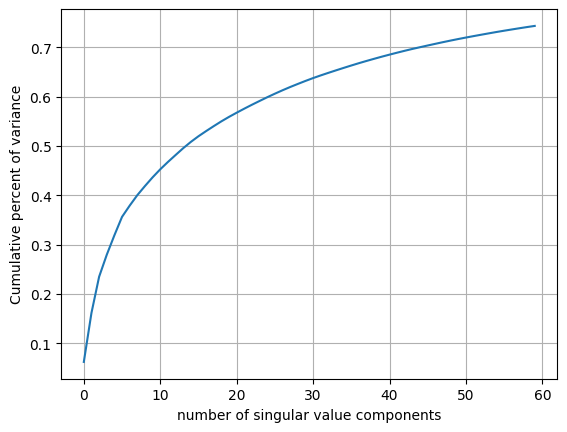

In [ ]:
# I plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [ ]:
# # As we can see, 60 components are able to explain more that 70% of variance so we keep this number of latent components.
n = 60
latent_df = pd.DataFrame(latent_df[:,0:n], index=merged_df["category_restaurant"].tolist())
latent_df.shape

(12931, 60)

In [ ]:
# I need the user_id as column and every restaurant as index
ratings = merged_df.pivot(index = 'category_restaurant', columns ='user_id', values = 'stars').fillna(0)
display(ratings.head())
ratings.shape

user_id,--RRf-2d2CKi3yGQ9QqrsQ,--f7c9Mlug2QcYA7aCzxYg,-0J1O0JAdP9e5zhPGaxmDQ,-1Tus48MIpw1ljZa4TTv8g,-1yGJJLmqVsEftxCF_u24Q,-2H3MnKkG2H-6sj_-u7nbA,-2WXHI0UtH4v6OCnF10ENA,-3i9bhfvrM3F1wsC9XIB8g,-4-985rzvuxiwGo65ipN4Q,-4_k04L53waXSyxvO_uC7w,...,zu0IhXrgGvbpXUDSR8MNSw,zuwfsz5HcrSIsYjJTbSkyg,zvb8LI9RtTNh5zY4tk-9mw,zvcGqpm7Qk616gP0mzQAFQ,zwaH6r7od897H1Qss_S0Eg,zxZs7x3axV42VCNrRV5tuQ,zy5rvDRgPG1JUNbixZxwUQ,zyI9VlFrSAjZpFEb6i9Ccw,zzXNLpbLmNzcC7h7mGonNQ,zzo--VpSQh8PpsGVeMC1dQ
category_restaurant,,,,,,,,,,,,,,,,,,,,,
--DaPTJW3-tB1vP-PfdTEg Restaurants;Breakfast & Brunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--S62v0QgkqQaVUhFnNHrw Breakfast & Brunch;American (Traditional);Restaurants;Diners,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--SrzpvFLwP_YFwB_Cetow Restaurants;Chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0NrB58jqKqJfuUCDupcsw Food;Bars;Korean;Nightlife;Soul Food;Restaurants;Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0aOudcaAyac0VJbMX-L1g Restaurants;Pizza;Middle Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(5324, 6973)

In [ ]:
# Calculate latent vectors for a X restaurant from content matrix
v1 = np.array(latent_df.loc['--DaPTJW3-tB1vP-PfdTEg Restaurants;Breakfast & Brunch']).reshape(1, -1)

# Compute the cosine similarity of this X restaurant with the others 
sim1 = cosine_similarity(latent_df, v1).reshape(-1)


In [ ]:
## I create a df with info
dictDf = {'content': sim1} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index)
recommendation_df.head()

,content
z_GjAY3UfxHNa5SDafxyDw Restaurants;Mexican,0.410457
uh7DUWtPoZkuEE05fghJ_w Restaurants;American (New);Lounges;Bars;Tapas Bars;Nightlife,0.189058
DYAorbxOyubUB_wtQRCdug Food;Sandwiches;American (New);Coffee & Tea;Restaurants;Bakeries,0.206325
a0v7Si0DK4cIko7AQY4YXg Breakfast & Brunch;Restaurants;American (Traditional),0.774489
Se-co1eXBho5A4YwMfKMIQ Breakfast & Brunch;Salad;Restaurants;Sandwiches,0.776749


In [ ]:
## Drop duplicates
recommendation_df1 = recommendation_df.drop_duplicates()

### *Finally we obtain restaurant suggestions, for those users who visited this X restaurant: '--DaPTJW3-tB1vP-PfdTEg Restaurants;Breakfast & Brunch'*

In [ ]:
## Final sorted df
recommendation_df1.sort_values('content', ascending=False, inplace=True)
recommendation_df1.head(50)

C:\Users\murre\AppData\Local\Temp\ipykernel_3504\3730238036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendation_df1.sort_values('content', ascending=False, inplace=True)


,content
VatWIJnfdVahCRQWDMqEyQ Restaurants;Breakfast & Brunch,1.000000
At2bqa8emnEr5WNIosi0ow Restaurants;Breakfast & Brunch,1.000000
Aob9kNExpqUX5zD5culM9A Restaurants;Breakfast & Brunch,1.000000
AabR8NEwbwoGhQxJohs0OQ Restaurants;Breakfast & Brunch,1.000000
dVkQImhIn-9BgYnm1yCUKA Restaurants;Breakfast & Brunch,1.000000
z82CyKgRSX2KyUWgphygtg Restaurants;Breakfast & Brunch,1.000000
mTD9IKo7loPg6QTLDcL6YQ Restaurants;Breakfast & Brunch,1.000000
EWo5usxVpjAs25NFBbsITQ Restaurants;Breakfast & Brunch,1.000000
kQkXA0t1IBECrIZQVdFQ5Q Restaurants;Breakfast & Brunch,1.000000
jxbEwtV8Et1lm8ubk4AGuw Restaurants;Breakfast & Brunch,1.000000


### As expected, the engine suggests other restaurants for breakfast & brunch.